# Image Scene Classification of Multiclass labels

## The objective of this kernel is to implement CNN with Keras in order to classify natural images.



The dataset can be dowloaded from here : https://www.kaggle.com/puneet6060/intel-image-classification

The input is image data of Natural Scenes around the world.

This Data contains around 25k images of size 150x150 distributed under 6 categories.

'buildings' -> 0,

'forest' -> 1,

'glacier' -> 2,

'mountain' -> 3,

'sea' -> 4,

'street' -> 5 



### Load all the required libraries

In [30]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from random import randint

import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.applications.inception_v3 import InceptionV3

print("Setup Complete!")

Setup Complete!


### Display random images from the dataset

In [9]:
def get_images(directory):
    Images = []
    Labels = []  # 0 for Building , 1 for forest, 2 for glacier, 3 for mountain, 4 for Sea , 5 for Street
    label = 0
    
    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        if labels == 'glacier': #Folder contain Glacier Images get the '2' class label.
            label = 2
        elif labels == 'sea':
            label = 4
        elif labels == 'buildings':
            label = 0
        elif labels == 'forest':
            label = 1
        elif labels == 'street':
            label = 5
        elif labels == 'mountain':
            label = 3
        
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(150,150)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            Images.append(image)
            Labels.append(label)
        
#     return Images, Labels
    return shuffle(Images,Labels,random_state=817328462) #Shuffle the dataset you just prepared.

def get_classlabel(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}
    
    return labels[class_code]

In [17]:
Images, Labels = get_images('../input/intel-image-classification/seg_train/seg_train/') #Extract the training images from the folders.

Images = np.array(Images, dtype=np.float32) #converting the list of images to numpy array.
Images = Images/255.0
Labels = np.array(Labels)

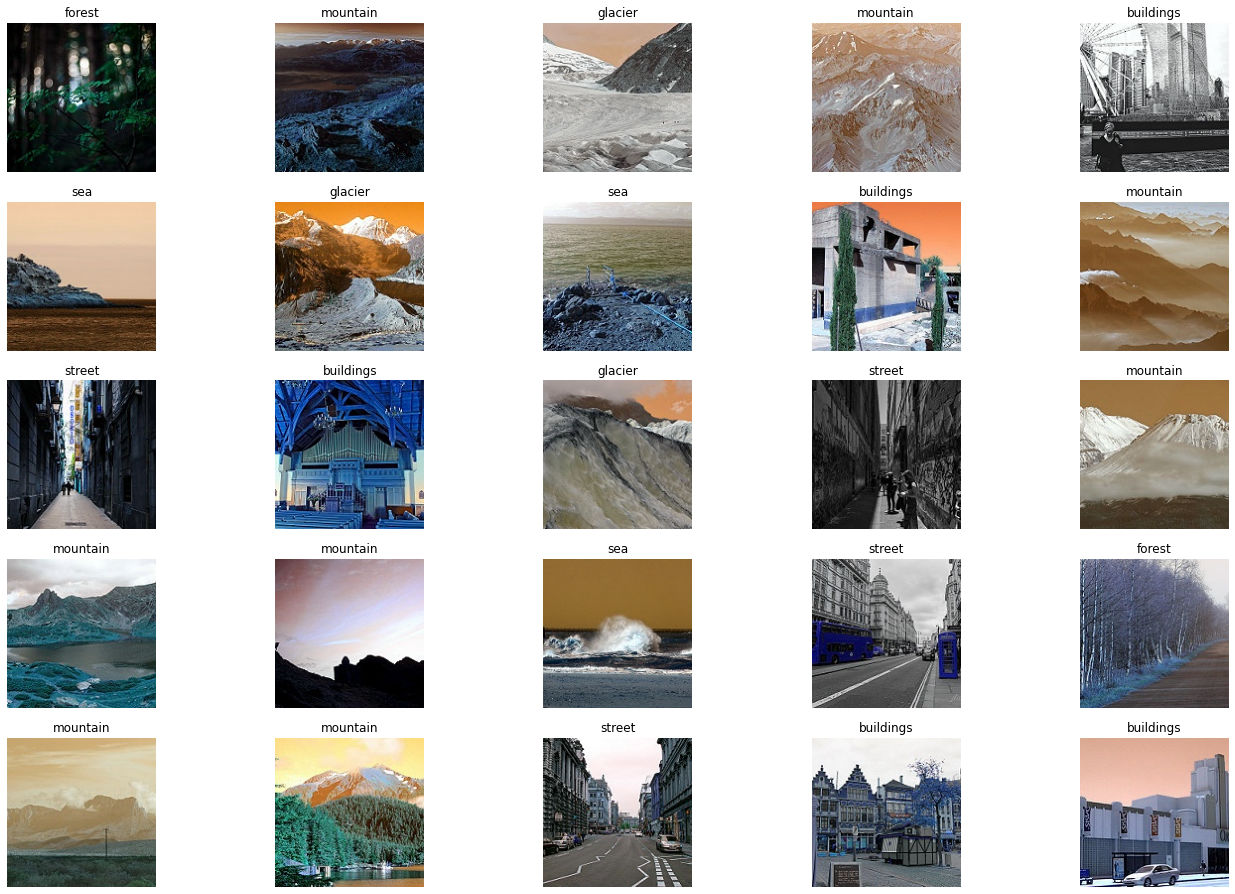

In [24]:
f,ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(Images))
        ax[i,j].imshow(Images[rnd_number])
        ax[i,j].set_title(get_classlabel(Labels[rnd_number]))
        ax[i,j].axis('off')

In [2]:

train_DIR = "/kaggle/input/intel-image-classification/seg_train/seg_train/"

train_datagen = ImageDataGenerator( rescale = 1.0/255,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          zoom_range=0.2,
                                          vertical_flip=True,
                                          fill_mode='nearest')


train_generator = train_datagen.flow_from_directory(train_DIR,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

test_DIR = "/kaggle/input/intel-image-classification/seg_test/seg_test/"

validation_datagen = ImageDataGenerator(rescale = 1.0/255)


validation_generator = validation_datagen.flow_from_directory(test_DIR,
                                                    batch_size=128,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [3]:
inceptionV3 = InceptionV3(include_top= False, input_shape=(150,150,3))

for layer in inceptionV3.layers:
	layer.trainable = False

87916544/87910968 [==============================] - 1s 0us/step


In [4]:
last_layer = inceptionV3.get_layer('mixed9')

print('last layer output shape: ', last_layer.output_shape)

last_output = last_layer.output

last layer output shape:  (None, 3, 3, 2048)


In [5]:

x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(units = 1024, activation = tf.nn.relu)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense  (6, activation = tf.nn.softmax)(x)

model = tf.keras.Model( inceptionV3.input, x)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=1,
                                            verbose=1,
                                            factor=0.25,
                                            min_lr=0.000003)

model.compile(loss = 'categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(), metrics=['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
history = model.fit(train_generator,
                    epochs = 10,
                    verbose = 1,
                   validation_data = validation_generator,
                   callbacks=[learning_rate_reduction])

Epoch 1/10
439/439 [==============================] - 195s 444ms/step - loss: 0.5356 - acc: 0.8171 - val_loss: 0.2974 - val_acc: 0.8880 - lr: 0.0010
Epoch 2/10
439/439 [==============================] - 96s 219ms/step - loss: 0.3781 - acc: 0.8610 - val_loss: 0.2681 - val_acc: 0.8997 - lr: 0.0010
Epoch 3/10
439/439 [==============================] - 111s 252ms/step - loss: 0.3589 - acc: 0.8681 - val_loss: 0.2668 - val_acc: 0.9023 - lr: 0.0010
Epoch 4/10
439/439 [==============================] - ETA: 0s - loss: 0.3307 - acc: 0.8787
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
439/439 [==============================] - 111s 254ms/step - loss: 0.3307 - acc: 0.8787 - val_loss: 0.3102 - val_acc: 0.8830 - lr: 0.0010
Epoch 5/10
439/439 [==============================] - 108s 247ms/step - loss: 0.2796 - acc: 0.8935 - val_loss: 0.2395 - val_acc: 0.9110 - lr: 2.5000e-04
Epoch 6/10
439/439 [==============================] - 111s 252ms/step - loss: 0.2647 - acc: 

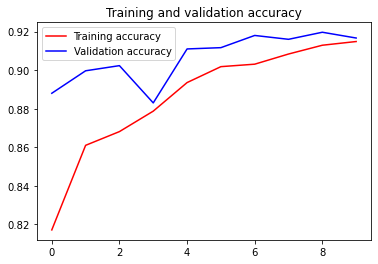

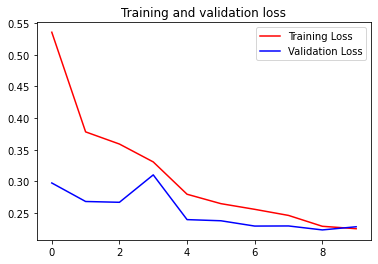

In [23]:
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Predictions 

Prediction for this image is : buildings


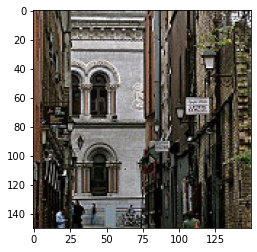

In [77]:
import numpy as np
from keras.preprocessing import image

file_path =  '../input/intel-image-classification/seg_pred/seg_pred/10073.jpg'

test_image = image.load_img(file_path, target_size = (150, 150))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)

classes=train_generator.class_indices

classes=['buildings','forest','glacier','mountain','sea','street']

print("Prediction for this image is :",classes[np.argmax(result)])